This first simple module will add the relevant packages (this only needs to be done once on any device) and then go through a simple calculation of the rotational transform profile.  It will also explain some of the Julia specific code pieces that may not be familiar to people coming from python.

Like python Julia has a command line implementation (called REPL).  One way of using these workbooks is to copy and paste the codeblocks into your version of REPL.

The first step is to add the public packages PlasmaEquilibriumToolkit and VMEC that are useful for the calculation.  PlasmaEquilibriumToolkit (PET) for short is not actually used in this workbook, but we add it because it will be used in subsequent workbooks.  We also add the NETCDF package necessary for reading the VMEC wout files, and a Plots package.  You may already have the latter two packages installed, but just in case they're included here.  These commands will download packages to your computer and install them.  It is similar to "pip install" in python. As with python you may want to occasionally upgrade the packages, especially since we are constantly improving them.  The output of this line in Jupyter should be "red" which normally indicates an error, but this is ok here. Note this will also install other needed packages, like Interpolations automatically.

In [3]:
using Pkg
Pkg.add(url="https://gitlab.com/WISTELL/PlasmaEquilibriumToolkit.jl.git")
Pkg.add(url="https://gitlab.com/WISTELL/VMEC.jl.git")
Pkg.add("NetCDF")
Pkg.add("Interpolations")
Pkg.add("Plots")

    Updating git-repo `https://gitlab.com/WISTELL/PlasmaEquilibriumToolkit.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Manifest.toml`
    Updating git-repo `https://gitlab.com/WISTELL/VMEC.jl.git`
   Resolving package versions...
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
    Updating `C:\Users\benja\.julia\environments\v1.6\Project.toml`
  [a98d9a8b] + Interpolations v0.13.1
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\benja\.julia\environments\v1.6\Project.toml`
  No Change

Once your computer has downloaded the packages with the add package command above, you can tell the code that we want to use them.  In this case we use the PET and VMEC packages along with the standard packages NetCDF and Plots

In [4]:
using PlasmaEquilibriumToolkit
using VMEC
using NetCDF
using Plots
using Interpolations

Once the packages are loaded we can read a VMEC file.  First we open it with NetCDF and then we read it into VMEC. You will need to change the line to read your own wout file

The second command readVmecWout is the most important command of this workbook.  It takes a faithful representation of the wout file and converts it into two types, the `Vmec` and `VmecData` types.  The `VmecData` type (given as `vmecdata`) is a faithful representation of the VMEC data as it appears in the wout file, represented in a native Julia `struct` that is easy to call.  If you're used to working with VMEC variables directly, you can just access them by using `vmecdata.variablename` or `getfield(vmecdata,:variablename)`.  This will return the value of the variable in usual format, for example `vmecdata.rmnc` returns an array with dimensions `(mnmax x ns)`.  Below we will use this to plot the rotational transform using `vmecdata.iotaf`.

However, using direct vmec data is inconvenient for several reasons.  Certain variables are plotted on different grids. Any value off of a grid point will require an interpolation routine.  And some of the variables are confusingly named from years of legacy.  Therefore we include a separate type called `Vmec` (instantiated here as `vmec`) which has the following features:

- All radial variables are fit to splines over the radial coordinate (we use "s" the normalized toroidal flux) using the `Interpolations` package. One can then call access the radial value of the desired quantity at any point between `s = [0,1]` using function-like syntax, for example `vmec.iota(0.273)`.
    - Functions of two variables, like the Fourier modes are spline fit for each mode over the radial variable and represented by a `Vector` of spline objects.  So the vector vmecdata.rmnc(radial position, fourier mode) becomes an array of splines: vmec.rmnc(fourier mode) 
- Derivatives of quantities in the radial direction are readily available from the spline fits.  (Other functions exist for calculating derivatives in the other two directions, we'll see them in other workbooks)

In [ ]:
wout = NetCDF.open("/home/bfaber/projects/julia/jupyter/wout_aten_reactor.nc");
vmec, vmecdata = VMEC.readVmecWout(wout);

We can inspect the `vmec` and `vmecdata` objects to see how the data is structured.  To see all the fieldnames of the `vmecdata` variable, use the `propertynames` function.  We can also check if a field defined with the `hasfield` function where the fieldname is the typical wout file variable name.  Note that the variable names are case sensitive.

In [10]:
propertynames(vmecdata)

(:rmnc, :rmns, :zmnc, :zmns, :lmnc, :lmns, :bmnc, :bmns, :gmnc, :gmns, :bsubsmnc, :bsubsmns, :bsubumnc, :bsubumns, :bsubvmnc, :bsubvmns, :bsupumnc, :bsupumns, :bsupvmnc, :bsupvmns, :currumnc, :currumns, :currvmnc, :currvmns, :xm, :xn, :xm_nyq, :xn_nyq, :phi, :phips, :phipf, :iotaf, :iotas, :pres, :presf, :beta_vol, :mnmax, :mnmax_nyq, :Aminor_p, :Rmajor_p, :aspect, :betaxis, :rmax_surf, :zmax_surf, :ns, :mpol, :ntor, :signgs, :nfp, :lasym, :filename_nc)

In [11]:
hasfield(VmecData,:gmnc)

true

The data fields consisting of Fourier modes in the `Vmec` type are no longer differentiated between the cosine and sine contributions, instead the radial spline are split between symmetric and asymmetric terms.  If the `lasym` flag is defined to be true in the wout file, then each entry for Fourier data in the `Vmec` type is given by
```julia
mn_max-element Vector{Tuple{Float64,Float64,Interpolations.Extrapolation,Interpolations.Extrapolation}}:
[0,0,symmetricSpline,asymmetricSpline]
    .
    .
    .
[m,n-1,symmetricSpline,asymmetricSpline]
[m,n,symmetricSpline,asymmetricSpline]
[m,n+1,symmetricSpline,asymmetricSpline]
    .
    .
    .
[M-1,N,symmetricSpline,asymmetricSpline]
```
If `lasym = F`, then the `asymmetricSpline` component is not included in the data structure.  The value of `mn_max` will either be the VMEC `mnmax` or `mnmax_nyq` depending on the data field.  Because the cosine and sine designations have been dropped, the fields in the `Vmec` type are also no longer delineated by a `c` or `s` ending.  We can see this by looking at, for example, the `(0,0)` mode of `rmn` field of the `vmec` object:

In [17]:
vmec.rmn[1]

(0.0, 0.0, 101-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:102), BSpline(Cubic(Line(OnGrid())))), (0.0:0.01:1.0,)), Throw()) with element type Float64:
 10.379738164423332
 10.378771331124
 10.376606623615979
 10.373722150537686
 10.370546780108523
 10.367226374891425
 10.363836060199088
 10.360404122121043
 10.356940123010316
 10.35344638990401
 10.349923310923833
 10.346370778414121
 10.3427893493877
  ⋮
 10.070170212730247
 10.067146627033042
 10.064141862965817
 10.061155677399919
 10.058187779345477
 10.0552376673532
 10.052304756471244
 10.049388155290405
 10.046486724832777
 10.043598680737523
 10.040721421059155
 10.037851131539265)

Here the column of numbers are the radial values of `rmn` that the interpolation is computed from.  For data such as the rotational transform which has radial dependence only, the data field is an `Interpolations` object, and can be used as such:

In [19]:
vmec.iota(π/10)

0.7839723979832921


The next step is to plot the data.  First we use the raw vmecdata, which you might be used to if you've used VMEC outputs before.

VMEC calls the toroidal flux "phi".  First we take the value at the edge, and then we divide all the values of phi by this value. This gives us the array of s values in vmec.  (VMEC's surfaces are evenly spaced in s, so you can also compute this quantity from the number of flux surfaces)

Once we have the array of s values, we plot iotaf, using the plot command from the Plots library.  This should look similar to matlab, or matplotlib plotting commands, so if you're familiar with those Julia should be easy.

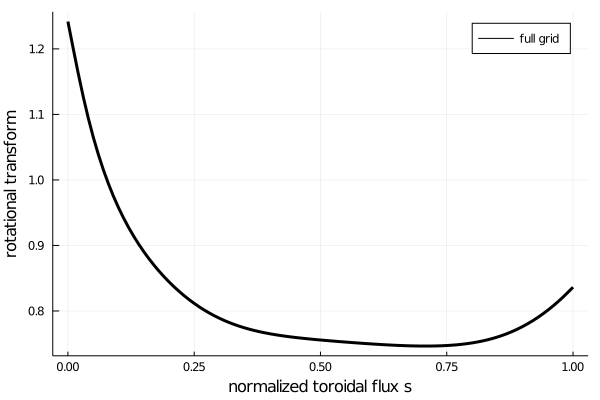

In [20]:
phiedge = vmecdata.phi[end];
sfull = vmecdata.phi ./ phiedge;

plot(sfull,vmecdata.iotaf,xaxis="normalized toroidal flux s", label="full grid",
    yaxis="rotational transform",linewidth=3,linecolor=:black )


We will plot this a second way using the vmec information.  (Ask Ben if he's fixed the inability to extrapolate off either end). 

vmec.iota is a spline function, so it has options that we can use.

We first get the range of S values spanned by vmec.iota and store those as sMin and Smax.  These represent the actual first and last nodes of the spline.

We then construct a high resolution s value using the standard function LinRange (similar to matlab linspace command)

Then we calculate a high-resolution array of iota values by simply calling vmec.iota using our high resolution s array as the argument.  The spline function knows what to do.

Finally we overplot it (the ! command to plot tells Julia to put it on the same plot as before)

You can't see much difference on the two plots, but the red dashed lines have many more points than the solid black lines.

The development speed-up you get with using our vmec library for plotting something simple like iota is not big, but for more complicated quantities and calculations, it will be more apparent.  We'll see this in future workbooks.

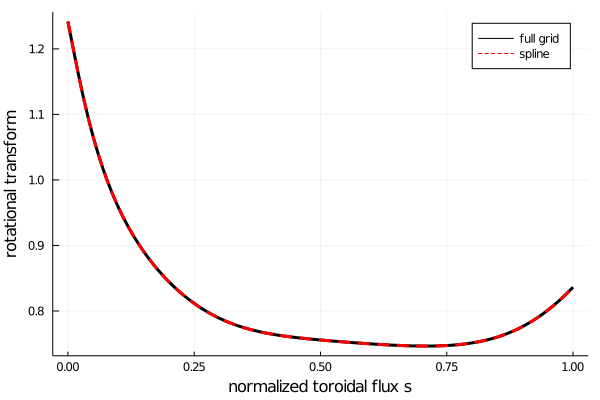

In [21]:
#find the ranges of the bspline (note it's not exactly s=0 to s=1
sMin = vmec.iota.itp.ranges[1][1];
sMax = vmec.iota.itp.ranges[1][end];

#construct a high resolution, uniformly spaced s array between these values
nRes = 1000;
sHires = LinRange(sMin,sMax,nRes);

#calculate the rot. transform values on the array
iotaHires = vmec.iota[sHires];

#overplot it
plot!(sHires,iotaHires,label="spline", linestyle=:dash,
     linewidth=3,linecolor=:red)


Where the new implementation really shines is with calculating quantities like derivatives. Here we plot d (iota) / ds as a function of s using the "gradient" function.

To do this we call the gradient function which takes a spline (in our case vmec.iota) and a value, and outputs a single element array.  Taking the first value of this array gives a float.  We use the map command to quickly iterate through all values of x in sHires (you could also do this with a for loop, but is much more concise with map)

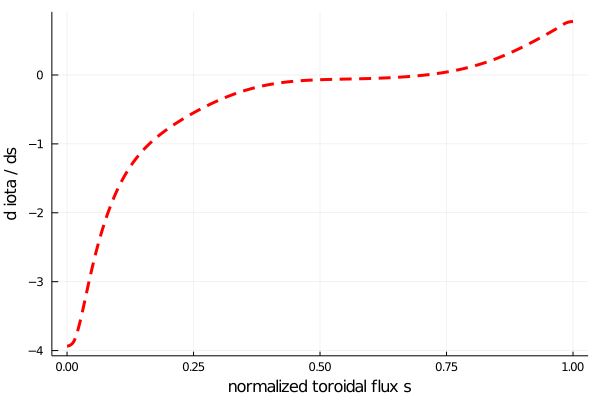

In [22]:
iotaPrime = map(x->Interpolations.gradient(vmec.iota, x)[1], sHires);
plot(sHires, iotaPrime, linestyle = :dash, linewidth = 3, linecolor = :red, 
    xaxis="normalized toroidal flux s", yaxis = "d iota / ds", label = "")